# PySPH tutorial: Getting started

*Prabhu Ramachandran*

Department of Aerospace Engineering, IIT Bombay

----


## Installation and getting started

This is a simple introduction to PySPH.  The PySPH documentation is here: http://pysph.readthedocs.io

1. First install PySPH.  See here: http://pysph.readthedocs.io/en/latest/installation.html
2. Go over the installation and getting started page


Importantly, once you have PySPH installed run a simple example, as so:

    $ pysph run elliptical_drop
    
or

    $ pysph run rigid_body.bouncing_cubes
    
    
Then view the generated output:

    $ pysph view elliptical_drop_output
    
    
If this produces a nice looking view, you should be mostly set.  It may be handy to be able to run pysph on openmp:

    $ pysph run elliptical_drop --openmp

If you get this far and everything works, you should be in good shape.


## More on the examples


The examples are all written in pure Python.  To see the sources for the examples you could either visit the github sources here: https://github.com/pypr/pysph/tree/master/pysph/examples

Alternatively try this:

    $ pysph run
    
Now you can pick among 40 odd examples.  To see the source of a simple one you can do the following:


    $ pysph run --cat elliptical_drop
    
    
This will simply show you the source code without executing it.  You could have also run the example by changing directory into the `<pysph_root>/pysph/examples` directory and running the example, for example let us do this easily as follows:


    $ pysph run --cat elliptical_drop > ed.py    # This puts the source into ed.py in the current dir.
    
    $ python ed.py
    
**NOTE: **  there is also a `<pysph_root>/old_examples` directory which you should not use.
    
You can also import the examples from Python and thus could just as well have run this example as:

    $ python -m pysph.examples.elliptical_drop


The point I am making is that `pysph run` is not doing anything special at all, it just makes it a tad easier to run the examples.  These examples are usually quite useful and can also be subclassed if you wish to reuse them.




### Using the PySPH library


In order to simulate your own problems you need to understand the anatomy of a PySPH simulation.  All the examples typically will do the following:

1. Create some particles
2. Specify the equations for the inter-particle interactions.
3. Specify the integrators to use.
4. Put these together in an `Application` and run this application.


### Creating particles


In this tutorial we will mostly explore the creation of particles in PySPH.  In PySPH, particles are created in a data structure called a `ParticleArray`.  Let us consider an example.  Let us say we have a glass of water.  Clearly we have two "things", a glass vessel and the water inside it.  Since we wish to capture the interaction of the water with the vessel, we would create two `ParticleArray`s.  One for the vessel which we call `"solid"` and the other for the water which we call `"fluid"`.  

Some important points to note.  Each particle array 

- has a name (a string) which should be a valid Python variable name, `"fluid"` and `"solid"` are good as would be `"fluid1"` and `"fluid2"`.

- has a collection of various particle properties, like the position `x, y, z`, velocity components `u, v, w`, other scalar properties `m, h, rho` etc.  All of these properties are scalars.

- has a collection of "constants", which can have an arbitrary size but are internally stored as 1D arrays.

The properties are used for things that typically vary, from particle to particle.

The constants are used for things that are constant for all the particles.

Let us now try to create a particle array in order to understand it better.


In [2]:
from __future__ import print_function

In [3]:
from pysph.base.particle_array import ParticleArray

In [4]:
pa = ParticleArray(name='fluid', x=[0.0, 1.0], y=0, m=0.1)
print(pa.name, pa.x, pa.y, pa.m)

fluid [0. 1.] [0. 0.] [0.1 0.1]


Note that we set the name by a kwarg. 

#### Exercise

- Try creating a particle array without the name.
- While x was passed as a list, y and m were not, what is going on?
- Does this work with numpy arrays?  Try it!
- Does it work with numpy arrays of arbitrary shape?
- What if you have arrays passed of different sizes?!
- Can you add a new "crazy" property?


In [4]:
import numpy as np
newpa = ParticleArray(name='something', y=np.ones((2,2,2)),x=3)

In [5]:
newpa.y

array([1., 1., 1., 1., 1., 1., 1., 1.])

#### Solution

- You can create a particle array without a name but DON'T.
- NumPy arrays work and are ravelled, lists and constants work.
- Passing incompatible sizes is a problem and you will get an error.
- You can add any kind of property by passing a suitable kwarg.

In [6]:
pa = ParticleArray(name='fluid', x=[0.0, 1.0], y=0, m=0.1, crazy=25)

In [7]:
pa.crazy

array([25., 25.])

### Doing more

- How do we discover the properties?
- Use `pa.properties`
- What about constants?


In [8]:
pa.properties

{'crazy': <pyzoltan.core.carray.DoubleArray at 0x11718a9b0>,
 'gid': <pyzoltan.core.carray.UIntArray at 0x1171a40c0>,
 'm': <pyzoltan.core.carray.DoubleArray at 0x11718ae60>,
 'pid': <pyzoltan.core.carray.IntArray at 0x1171a4050>,
 'tag': <pyzoltan.core.carray.IntArray at 0x117174fa0>,
 'x': <pyzoltan.core.carray.DoubleArray at 0x11718aaa0>,
 'y': <pyzoltan.core.carray.DoubleArray at 0x11718a848>}

So what are the other strange properties?  We didn't add `gid, pid and tag`

So it looks like PySPH automatically adds some special props, what are these?  

- gid: is a global ID for each particle, it is useful in parallel.
- pid: represents the process ID for each particle, also relevant in parallel.
- tag: represents the kind of particle we have.

The `tag` property is probably the most useful.  It is representative of the kind of particles, the ones that are important are:

- Local: see `get_local_tag` below
- Remote: see `get_remote_tag` below
- Ghost: see `get_ghost_tag` below


**Questions**

- What is this pyzoltan stuff??  
- What is a DoubleArray, IntArray?  



In [9]:
pa.gid

array([4294967295, 4294967295], dtype=uint32)

In [10]:
pa.pid

array([0, 0], dtype=int32)

In [11]:
pa.tag

array([0, 0], dtype=int32)

In [12]:
from pysph.base.particle_array import get_local_tag, get_ghost_tag, get_remote_tag

In [13]:
print("Local:", get_local_tag())
print("Remote:", get_remote_tag())
print("Ghost:", get_ghost_tag())

Local: 0
Remote: 1
Ghost: 2


#### Digression CArrays

Let us answer the question "What is this pyzoltan, DoubleArray stuff?"

These are internal arrays that allow us to efficiently store and compute with these properties and have some useful features.

In [14]:
from pyzoltan.core.carray import DoubleArray

In [15]:
a = DoubleArray(5)
x = a.get_npy_array()
x[:] = 100

In [16]:
a[1]

100.0

In [17]:
a.append(203)
a.length

6

#### Exercise

- Find the default properties.
- Can you create a particle array with no properties in the constructor?

In [18]:
empty = ParticleArray(name='dummy')

In [19]:
empty.properties

{'gid': <pyzoltan.core.carray.UIntArray at 0x117174c90>,
 'pid': <pyzoltan.core.carray.IntArray at 0x117174d70>,
 'tag': <pyzoltan.core.carray.IntArray at 0x116e1a600>}

### Adding constants

Add them by passing a dictionary.

In [20]:
pa = ParticleArray(name='fluid', x=[0.0, 1.0], constants={'rho0': 1000})
pa.rho0

array([1000])

In [21]:
pa.constants

{'rho0': <pyzoltan.core.carray.LongArray at 0x11718a668>}

#### Exercises

- Create different kinds of constants and experiment
- Create a vector or a 2d array.  What happens to a 2d array?

In [5]:
import numpy as np

In [6]:
pa = ParticleArray(name='f', x=[0.0, 1.0], 
                   constants=
                   {'a': 1, 'b': [1,2,3], 'c': np.identity(10)})

In [7]:
pa.constants

{'a': <pyzoltan.core.carray.LongArray at 0x11a91e578>,
 'b': <pyzoltan.core.carray.LongArray at 0x11a91e5f0>,
 'c': <pyzoltan.core.carray.DoubleArray at 0x11a91ec08>}

In [25]:
pa.c

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### Particle array methods

There are many methods but some more useful than others.  Let us explore this

- `pa.get_number_of_particles()`


- `pa.add_constant()`
- `pa.add_property(...)`
- `pa.add_particles()`

- `pa.extend(n)`
- `pa.extract_particles(...)`
- `pa.remove_particles()`
- `pa.remove_property(prop)`
- `pa.remove_tagged_particles(tag)`


The output property arrays is an important attribute.  It is what determines what is dumped to disk when you save particle arrays or run simulations.

- `pa.set_output_arrays(list)`
- `pa.output_property_arrays`
- `pa.add_output_arrays(list)`

####  Exercise

- Explore all of the above methods.


In [26]:
pa.output_property_arrays

[]

In [1]:
type(np.arange(10))

NameError: name 'np' is not defined

In [15]:
pa.add_property('something')
pa.x = np.array([1.3,1.2])
pa.something = np.array([1,2])
pa.properties

{'gid': <pyzoltan.core.carray.UIntArray at 0x11a90e750>,
 'pid': <pyzoltan.core.carray.IntArray at 0x11a90e600>,
 'something': <pyzoltan.core.carray.DoubleArray at 0x11a9add70>,
 'tag': <pyzoltan.core.carray.IntArray at 0x111ce5fa0>,
 'x': <pyzoltan.core.carray.DoubleArray at 0x11a9176e0>}

Can also add properties with strides.  See the documentation for
`pa.add_property(...)`

here is an example


In [16]:
pa.add_property('A', data=2.0, stride=2)

In [17]:
# Now lets see what this does.
pa.A

array([2., 2., 2., 2.])

The strided property behaves just like any other so when you add/remove particles the right thing is done.

The `pa.add_output_arrays` is also important.

In [18]:
pa.add_output_arrays(['x'])
pa.output_property_arrays

['x']

- `pa.get_carray(prop)`: will get you the c array.
- `pa.get(props)`: returns properties.
- `pa.set(**props)`: sets the properties in one go

In [53]:
pa = ParticleArray(name='fluid', x=[1.0,2.0])
pa.add_particles(x=[13,12])
pa.x
pa.add_property(name='y', data=[10,2,3,4])

np.where(pa.x + pa.y < 10)[0]


array([1])

### The convenient `pysph.base.utils`

- For many standard problems, one requires a bunch of additional properties.
- Use the `pysph.base.utils` for these.

In [19]:
from pysph.base.utils import get_particle_array

In [20]:
from pysph.base.utils import get_particle_array_wcsph, get_particle_array_tvf_fluid, get_particle_array_gasd

In [21]:
pa = get_particle_array_wcsph(name='fluid', x=[1, 2], m=3)
pa.properties

{'arho': <pyzoltan.core.carray.DoubleArray at 0x11a9ba5f0>,
 'au': <pyzoltan.core.carray.DoubleArray at 0x11a956848>,
 'av': <pyzoltan.core.carray.DoubleArray at 0x11a9ba1b8>,
 'aw': <pyzoltan.core.carray.DoubleArray at 0x11a9ba140>,
 'ax': <pyzoltan.core.carray.DoubleArray at 0x11a9ba758>,
 'ay': <pyzoltan.core.carray.DoubleArray at 0x11a956050>,
 'az': <pyzoltan.core.carray.DoubleArray at 0x11a9ba320>,
 'cs': <pyzoltan.core.carray.DoubleArray at 0x11a9ba230>,
 'div': <pyzoltan.core.carray.DoubleArray at 0x11a9baaa0>,
 'dt_cfl': <pyzoltan.core.carray.DoubleArray at 0x11a9ada28>,
 'dt_force': <pyzoltan.core.carray.DoubleArray at 0x11a9ba398>,
 'gid': <pyzoltan.core.carray.UIntArray at 0x11a9aaf30>,
 'h': <pyzoltan.core.carray.DoubleArray at 0x11a9ba668>,
 'm': <pyzoltan.core.carray.DoubleArray at 0x11a9ba6e0>,
 'p': <pyzoltan.core.carray.DoubleArray at 0x11a9ba7d0>,
 'pid': <pyzoltan.core.carray.IntArray at 0x11a9aafa0>,
 'rho': <pyzoltan.core.carray.DoubleArray at 0x11a9adc08>,
 'rho0

#### Exercises

- Create particles inside a disk of radius 1.
- Visualize the particle positions.
- Create a WCSPH compatible particle array with these points.

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt

array([-0.26530612, -0.2244898 , -0.18367347, ...,  0.18367347,
        0.2244898 ,  0.26530612])

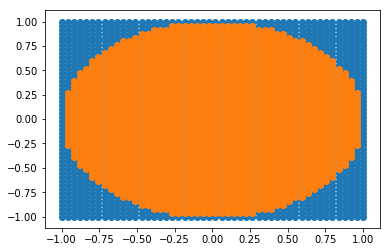

In [70]:
x = np.linspace(-1,1,50)
y = np.linspace(-1,1,50)
xm, ym = np.meshgrid(x, y)
condition = np.where((xm**2 + ym**2) <= 1)
plt.scatter(xm, ym)
xm, ym = xm[condition], ym[condition]
plt.scatter(xm, ym)


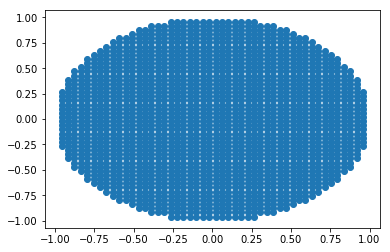

In [73]:
plt.scatter(xm, ym)

In [74]:
pa = get_particle_array_wcsph(name='fluid', x=xm, y=ym)

#### Solution

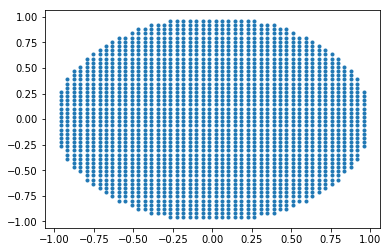

In [76]:
# %load solutions/particles_in_disk.py
import numpy as np
from pysph.base.utils import get_particle_array_wcsph
x, y = np.mgrid[-1:1:50j, -1:1:50j]
mask = x*x + y*y < 1.0
pa = get_particle_array_wcsph(name='fluid', x=x[mask], y=y[mask])
plt.scatter(pa.x, pa.y, marker='.')